In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys; sys.path.append('..')
import random, math
import pyzx as zx
from fractions import Fraction
from pyzx.phasepoly import circuit_phase_polynomial_blocks, optimize_block
%config InlineBackend.figure_format = 'svg'

In [278]:
#random.seed(138323)
import itertools
qubit_amount = 7
depth = 800
for i in range(1,40):
    if i%1 == 0: print(i,end='.')
    circ = zx.cliffordT(qubit_amount, depth,p_t=0.2)#, p_hsh=0.0)
    g = circ.copy()
    zx.simplify.full_reduce(g, quiet=True)
#     zx.simplify.clifford_simp(g,quiet=True)
#     gadgets = set(zx.simplify.gadgetize(g))

#     # don't pivot an edge adjacent to a gadget vertex
#     matchf = lambda e: not (g.edge_s(e) in gadgets or g.edge_t(e) in gadgets)
#     zx.simplify.pivot_simp(g,matchf=matchf,quiet=True)
#     zx.simplify.lcomp_simp(g,quiet=True)
#     zx.simplify.pivot_simp(g,matchf=matchf,quiet=True)
    #zx.clifford_simp(g,quiet=True)
    #c = zx.extract.streaming_extract(g).to_basic_gates()
    #c2, blocks = circuit_phase_polynomial_blocks(c, optimize=True)
    #g.normalise()
    #gg = g
    #g = gg.copy()
    g.normalise()
    gadgets = {}
    targets = {}
    for v in g.vertices():
        if v not in g.inputs and v not in g.outputs and len(list(g.neighbours(v)))==1:
            n = list(g.neighbours(v))[0]
            tgts = frozenset(set(g.neighbours(n)).difference({v}))
            gadgets[n] = tgts
            if len(tgts)>4: continue
            for t in tgts:
                if t in targets:
                    targets[t].add(tgts)
                else: targets[t] = {tgts}
        if g.phase(v) != 0 and g.phase(v).denominator > 2:
            if v in targets: targets[v].add(frozenset([v]))
            else: targets[v] = {frozenset([v])}
    targets = {t:s for t,s in targets.items() if len(s)>1}
    m = find_group(targets)
    if m:
        print("Match!")
        print(m)
        break
#     should_break = False
#     for group in itertools.combinations(targets.keys(), 4):
#         a = set()
#         for t in group: a.update([s for s in targets[t] if s.issubset(group)])
#         if len(a)>7:
#             print("Match!")
#             print(group)
#             print(a)
#             should_break = True
#             break
#     for v, par1 in gadgets.items():
#         for w,par2 in gadgets.items():
#             if v>=w: continue
#             if w in par1:
#                 if par1.difference({w}) == par2.difference({v}):
#                     print(v,w, par1,par2)
#                     should_break=True
#                     break
#         if should_break: break
    #if should_break: break
#if should_break:
#    display(zx.draw(g,labels=True))
#zx.draw(c2.to_graph(),labels=False,figsize=(25,3))

1.2.3.Match!
{frozenset({1089, 1091, 1103, 1087}): {frozenset({1091}), frozenset({1091, 1087, 1103}), frozenset({1103}), frozenset({1087}), frozenset({1089}), frozenset({1089, 1091}), frozenset({1089, 1091, 1087}), frozenset({1089, 1103})}}


In [256]:
def find_group(targets):
    matches = {}
    for v1,t1 in targets.items():
        s = t1.difference(frozenset([v1]))
        if len(s) == 1:
            c = s.pop()
            if any(len(targets[v2])==2 for v2 in c): continue
        s = t1.difference(frozenset([v1]))
        for c in [d for d in s if not any(d.issuperset(e) for e in s if e!=d)]:
            if not all(v2 in targets for v2 in c): continue
            if any(v2<v1 for v2 in c): continue
            a = set()
            for t in c: a.update([i for s in targets[t] for i in s if i in targets])
            for group in itertools.combinations(a.difference(c),4-len(c)):
                group = list(group)+list(c)
                a = set()
                for t in group: a.update([s for s in targets[t] if s.issubset(group)])
                if len(a)>7:
                    matches[frozenset(group)] = a
    return matches

find_group(targets)

{frozenset({550, 556, 558, 562}): {frozenset({550}),
  frozenset({556, 562}),
  frozenset({550, 556}),
  frozenset({562}),
  frozenset({558}),
  frozenset({558, 562}),
  frozenset({556}),
  frozenset({550, 556, 562})}}

In [293]:

def match_gadgets_phasepoly(g):
    targets = {}
    gadgets = {}
    for v in g.vertices():
        if v not in g.inputs and v not in g.outputs and len(list(g.neighbours(v)))==1:
            n = list(g.neighbours(v))[0]
            tgts = frozenset(set(g.neighbours(n)).difference({v}))
            if len(tgts)>4: continue
            gadgets[tgts] = (n,v)
            for t in tgts:
                if t in targets: targets[t].add(tgts)
                else: targets[t] = {tgts}
        if g.phase(v) != 0 and g.phase(v).denominator > 2:
            if v in targets: targets[v].add(frozenset([v]))
            else: targets[v] = {frozenset([v])}
    targets = {t:s for t,s in targets.items() if len(s)>1}

    matches = {}

    for v1,t1 in targets.items():
        s = t1.difference(frozenset([v1]))
        if len(s) == 1:
            c = s.pop()
            if any(len(targets[v2])==2 for v2 in c): continue
        s = t1.difference(frozenset([v1]))
        for c in [d for d in s if not any(d.issuperset(e) for e in s if e!=d)]:
            if not all(v2 in targets for v2 in c): continue
            if any(v2<v1 for v2 in c): continue
            a = set()
            for t in c: a.update([i for s in targets[t] for i in s if i in targets])
            for group in itertools.combinations(a.difference(c),4-len(c)):
                group = list(group)+list(c)
                a = set()
                for t in group: a.update([s for s in targets[t] if s.issubset(group)])
                if len(a)>7:
                    matches[frozenset(group)] = a

    m = []
    taken = set()
    for group, gad in sorted(matches.items(), key=lambda a: len(a[1]), reverse=True):
        if taken.intersection(group): continue
        gad = list(gad)
        m.append((group, gad, {s:(gadgets[s] if len(s)>1 else list(s)[0]) for s in gad}))
        taken.update(group)

    return m

match_gadgets_phasepoly(g)

[(frozenset({1087, 1089, 1091, 1103}),
  [frozenset({1091}),
   frozenset({1087, 1091, 1103}),
   frozenset({1103}),
   frozenset({1087}),
   frozenset({1089}),
   frozenset({1089, 1091}),
   frozenset({1087, 1089, 1091}),
   frozenset({1089, 1103})],
  {frozenset({1091}): 1091,
   frozenset({1089}): 1089,
   frozenset({1089, 1091}): (1092, 1093),
   frozenset({1087}): 1087,
   frozenset({1087, 1089, 1091}): (1084, 1085),
   frozenset({1103}): 1103,
   frozenset({1087, 1091, 1103}): (1080, 1081),
   frozenset({1089, 1103}): (1098, 1099)})]

In [285]:
list(sorted({2,1,4,3,5},reverse=True))

[5, 4, 3, 2, 1]

In [99]:
g2 = g.copy()
for e in g2.edges(): g2.set_edge_type(e,1)
zx.quantomatic.quantomatic_location = r'C:\Users\John\Desktop\scala.jar'
zx.quantomatic.edit_graph(g2)

Opening Quantomatic...


KeyboardInterrupt: 

In [52]:
from pyzx.circuit import SWAP
g = gg.copy()
c = zx.extract.streaming_extract(g)
swaps = []
for g in c.gates.copy():
    if isinstance(g, SWAP):
        swaps.append(g)
        c.gates.remove(g)
print(len(c.gates))
g = c.to_graph(compress_rows=True)
zx.simplify.id_simp(g,quiet=True)
zx.simplify.to_gh(g)
#zx.simplify.to_rg(g)
#zx.simplify.to_rg(g)
c = zx.Circuit.from_graph(g,split_phases=False)
print(len(c.gates))
zx.simplify.to_rg(g)
#zx.draw(g,figsize=(35,3),rows=(0,100))

1170
1328


In [53]:
from pyzx.phasepoly import circuit_phase_polynomial_blocks, optimize_block
c2, partition = circuit_phase_polynomial_blocks(c)
new_partition = []
for i in range(0,len(partition),2):
    new_partition.append(partition[i])
    if i+1<len(partition):
        block = optimize_block(partition[i+1],c.qubits)
        new_partition.append(block)

c3 = zx.Circuit(c.qubits)
for gs in new_partition: c3.gates.extend(gs)
print(len(c.gates), len(c2.gates),len(c3.gates))

1328 1162 1131


In [84]:
qubits = 12
depth = 800
prereduction = 0
reduction = 0
iterations = 100

for i in range(1,iterations+1):
    if i%20 == 0:
        print(i, end='.')
    seed = random.randint(0,100000)
    random.seed(seed)
    circ = zx.cliffordT(qubits, depth, p_t=0.2)
    g = circ.copy()
    zx.clifford_simp(g,quiet=True)
    g.normalise()
    c = zx.extract.streaming_extract(g)
    swaps = []
    for g in c.gates.copy():
        if isinstance(g, SWAP):
            swaps.append(g)
            c.gates.remove(g)
    g = c.to_graph(compress_rows=True)
    zx.simplify.id_simp(g,quiet=True)
    zx.simplify.to_gh(g)
    c2 = zx.Circuit.from_graph(g,split_phases=False)
    #c2, partition = circuit_phase_polynomial_blocks(c)
#     new_partition = []
#     for i in range(0,len(partition),2):
#         new_partition.append(partition[i])
#         if i+1<len(partition):
#             block = optimize_block(partition[i+1],c.qubits)
#             new_partition.append(block)

    c3, new_partition = circuit_phase_polynomial_blocks(c2, optimize=True)
    #for gs in new_partition: c3.gates.extend(gs)
    #if not zx.compare_tensors(c2.to_tensor(), c3.to_tensor()):
    #    raise Exception("Not equal")
    prereduction += depth - len(c.gates)
    reduction += len(c.gates) - len(c3.gates)

print("\nBefore reduction: ", prereduction/iterations)
print("Extra reduction: ", reduction/iterations)

20.40.60.80.100.
Before reduction:  64.14
Extra reduction:  35.66


In [79]:
len(c.gates), len(c3.gates)

(500, 586)

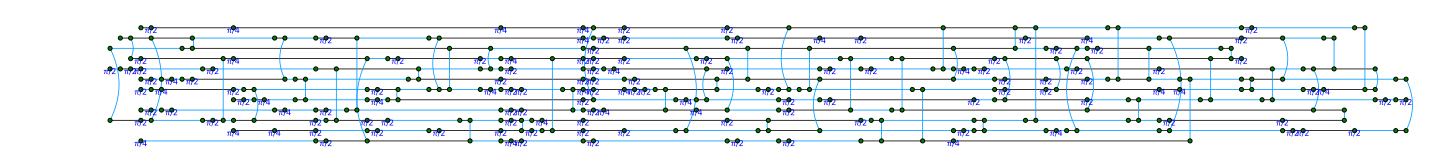

In [81]:
#c2, partition = c.get_phase_polynomial_blocks()
#print(len(c2.gates))
#print([len(partition[i]) for i in range(1,len(partition),2)])
g2 = c2.to_graph(compress_rows=True)

zx.draw(g2,figsize=(20,2),rows=(g2.depth()-250,g.depth()))

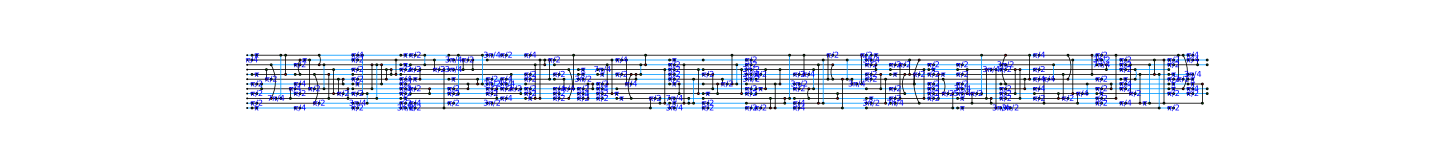

In [83]:
g3 = c3.to_graph(compress_rows=True)

zx.draw(g3,figsize=(20,2),rows=(0,200))

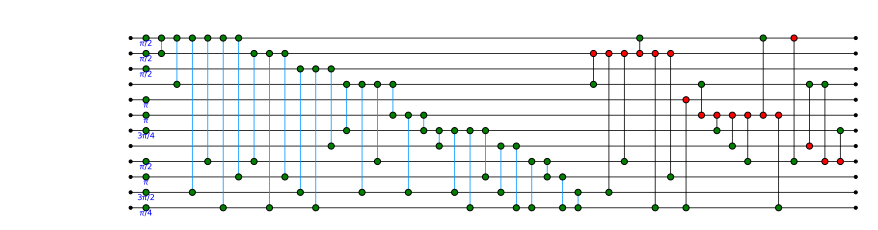

In [13]:
#for s in swaps: c2.add_gate(s)
#zx.compare_tensors(c2.to_tensor(), circ.to_tensor())
d1 = zx.Circuit(c.qubits)
d1.gates = partition[1]
        
zx.draw(d1.to_graph(), figsize=(12,3))

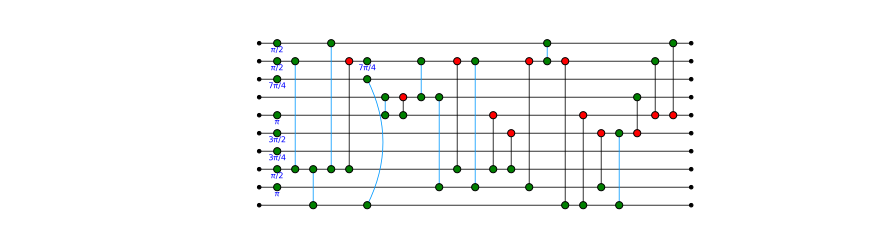

In [34]:
zx.draw(d2.to_graph(), figsize=(12,3))

In [19]:
from pyzx.circuit import HAD, CZ, ZPhase, CNOT
def phase_poly(block, qubit_count):
    q = qubit_count
    variables = ['x{:03d}'.format(i) for i in range(q)]
    phase_poly = BoolPolynomial()
    expression_polys = []
    for i in range(q):
        p = BoolPolynomial()
        p.add_term(variables[i],1)
        expression_polys.append(p)
    
    r = []

    for g in block:
        if isinstance(g, ZPhase):
            terms = expression_polys[g.target].terms
            if len(terms) == 1:
                term = list(terms.keys())[0]
            else:
                term = "({})".format("+".join(t[0] for t in terms.keys()))
            phase_poly.add_term(term, g.phase)
        elif isinstance(g, CZ):
            tgt, ctrl = g.target, g.control
            phase_poly.add_polynomial(expression_polys[tgt]*expression_polys[ctrl])
            r.append(phase_poly)
        elif isinstance(g, CNOT):
            tgt, ctrl = g.target, g.control
            expression_polys[tgt].add_polynomial(expression_polys[ctrl])
    
    print(phase_poly)
    
    simple_phases = []
    czs = []
    parities = []
    for t, phase in phase_poly.terms.items():
        if len(t) == 2:
            czs.append((variables.index(t[0]),variables.index(t[1])))
            continue
        t = t[0]
        if '+' in t:
            l = []
            for v in variables:
                l.append(int(v in t[1:-1].split('+')))
            parities.append((l,phase))
        else: simple_phases.append((variables.index(t), phase))
    
    czs = set(czs)
    print(simple_phases)
    print(czs)
    print(parities)
    return czs

r1 = phase_poly(d1.gates, d1.qubits)
#r2 = phase_poly(d2.gates, d2.qubits)
#print(r1)
#print(r2)

1/2x000 + x000x001 + x000x003 + x000x008 + x000x009 + x000x010 + x000x011 + 1/2x001 + x001x008 + x001x009 + x001x011 + 1/2x002 + x002x007 + x002x010 + x002x011 + x003x005 + x003x006 + x003x008 + x003x010 + x004 + x005 + x005x006 + x005x010 + 3/4x006 + x006x007 + x006x009 + x006x010 + x006x011 + x007x010 + x007x011 + 1/2x008 + x008x009 + x008x011 + x009 + x009x011 + 3/2x010 + x010x011 + 1/4x011
[(10, Fraction(3, 2)), (2, Fraction(1, 2)), (0, Fraction(1, 2)), (4, Fraction(1, 1)), (11, Fraction(1, 4)), (1, Fraction(1, 2)), (8, Fraction(1, 2)), (6, Fraction(3, 4)), (9, Fraction(1, 1)), (5, Fraction(1, 1))]
{(6, 9), (10, 11), (5, 6), (8, 9), (0, 10), (7, 11), (0, 3), (1, 11), (6, 7), (3, 10), (6, 10), (0, 11), (9, 11), (7, 10), (3, 6), (6, 11), (8, 11), (2, 10), (1, 9), (0, 8), (3, 5), (2, 7), (0, 1), (5, 10), (2, 11), (3, 8), (1, 8), (0, 9)}
[]


In [28]:
from pyzx.circuit import ZPhase, CNOT, CZ, HAD

def optimize_block(block, qubit_count):
    q = qubit_count
    #First we construct the phase polynomial
    variables = ['x{!s}'.format(i) for i in range(c.qubits)]
    phase_poly = BoolPolynomial()
    expression_polys = []
    for i in range(c.qubits):
        p = BoolPolynomial()
        p.add_term(variables[i],1)
        expression_polys.append(p)

    for g in block:
        if isinstance(g, ZPhase):
            terms = expression_polys[g.target].terms
            if len(terms) == 1:
                term = list(terms.keys())[0]
            else:
                term = "({})".format("+".join(t[0] for t in terms.keys()))
            phase_poly.add_term(term, g.phase)
        elif isinstance(g, CZ):
            tgt, ctrl = g.target, g.control
            phase_poly.add_polynomial(expression_polys[tgt]*expression_polys[ctrl])
        elif isinstance(g, CNOT):
            tgt, ctrl = g.target, g.control
            expression_polys[tgt].add_polynomial(expression_polys[ctrl])

#     print(phase_poly)
#     for p in expression_polys:
#         print(p)
    
    # Then we extract the parities for the CZs and phases
    simple_phases = []
    czs = []
    parities = []
    for t, phase in phase_poly.terms.items():
        if len(t) == 2:
            czs.append((variables.index(t[0]),variables.index(t[1])))
            continue
        t = t[0]
        if '+' in t:
            l = []
            for v in variables:
                l.append(int(v in t[1:-1].split('+')))
            parities.append((l,phase))
        else: simple_phases.append((variables.index(t), phase))
    
    czs = set(czs)
    
    #print(simple_phases)
    #print(czs)
    #print(parities)
    
    # We try to make our cnots more efficient
    q = c.qubits
    cnots = parity_network(q, [par for par,phase in parities])
    m = zx.linalg.Mat2.id(q)
    for cnot in cnots:
        m.row_add(cnot.control, cnot.target)

    data = []
    for p in expression_polys:
        l = [int((v,) in p.terms) for v in variables]
        data.append(l)
    target_matrix = zx.linalg.Mat2(data) * m.inverse()

    class CNOTMaker:
        def __init__(self):
            self.cnots = []
        def row_add(self, r1, r2):
            self.cnots.append(CNOT(r1,r2))

    best = 100000
    best_cn = None
    for size in range(2,q):
        cn = CNOTMaker()
        target_matrix.copy().gauss(full_reduce=True,x=cn, blocksize=size)
        if len(cn.cnots) < best:
            best = len(cn.cnots)
            best_cn = cn

    cnots = cnots + list(reversed(best_cn.cnots))
    old_cnots = [g for g in block if isinstance(g,CNOT)]

    if len(cnots) > len(old_cnots):
        print("New set of CNOTs is worse, using old set.", len(cnots), len(old_cnots))
        cnots = old_cnots

    m = zx.linalg.Mat2.id(q)
    cz_sites = {(0,r1,r2):[(r1,r2)] for r1 in range(q) for r2 in range(q) if r1<r2}
    cz_parities = list(cz_sites.values())
    phase_locations = []
    for i, cnot in enumerate(cnots):
        m.row_add(cnot.control, cnot.target)
        for par, phase in parities:
            if par in m.data:
                phase_locations.append((i+1,m.data.index(par),phase))
                parities.remove((par,phase))
                break
        for r1 in range(q):
            for r2 in range(r1+1, q):
                if any(m.data[r1][j] and m.data[r2][j] for j in range(q)):
                    continue
                l = set([(j1,j2) for j1 in range(q) if m.data[r1][j1] for j2 in range(q) if m.data[r2][j2]])
                if l not in cz_parities:
                    cz_sites[(i+1,r1,r2)] = l
                    cz_parities.append(l)
                    
    old_cz_count = sum(1 for g in block if isinstance(g,CZ))
    new_czs = []
    while czs:
        best = len(czs)
        choice = None
        for loc, l in cz_sites.items():
            score = len(czs.symmetric_difference(l))
            if score < best:
                best = score
                choice = loc
        if not choice:
            print(":(")
            print(czs)
        new_czs.append(choice)
        czs.symmetric_difference_update(cz_sites[choice])
    print("Old cz count: ", old_cz_count, ". New cz count: ", len(new_czs))
    
    new_block = []
    for loc, phase in simple_phases:
        new_block.append(ZPhase(loc,phase))
    for i, cnot in enumerate(cnots):
        for j, loc, phase in phase_locations:
            if j!=i: continue
            new_block.append(ZPhase(loc,phase))
        for j, r1, r2 in new_czs:
            if j!=i: continue
            new_block.append(CZ(r1,r2))
        new_block.append(cnot)
    
    return new_block

Old cz count:  1 . New cz count:  1


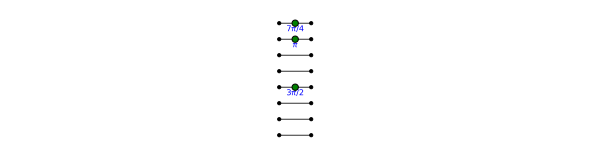

In [29]:
q = c.qubits

block = partition[7]

new_block = optimize_block(block, q)

c3 = zx.Circuit(q)
for g in new_block: c3.add_gate(g)

zx.draw(c3.to_graph(compress_rows=True))

In [231]:
c4 = zx.Circuit(q)
for g in block: c4.add_gate(g)

zx.compare_tensors(c3.to_tensor(),c4.to_tensor())

True

In [20]:
l = list(range(1000000))
isinstance(reversed(l),list)

False

In [11]:
m = zx.linalg.Mat2.id(4)
class CNOTMaker:
    def __init__(self):
        self.cnots = []
    def row_add(self, r1, r2):
        self.cnots.append(CNOT(r1,r2))

cn = CNOTMaker()
m.gauss(full_reduce=True,x=cn,blocksize=2)
cn.cnots

[]

In [21]:
from pyzx.circuit import T, S, Z, CZ, ParityPhase
from fractions import Fraction

class MultiLinearPoly:
    def __init__(self):
        self.l = {}
        self.q = {}
        self.c = set()
    
    def add_parity(self, par, subtract=False):
        p = []
        mult = -1 if subtract else 1
        for i,v in enumerate(par):
            if v: p.append(i)
        for a in range(len(p)):
            v1 = p[a]
            if v1 not in self.l: self.l[v1] = mult
            else: self.l[v1] = (self.l[v1] + mult) % 8
            
            for b in range(a+1, len(p)):
                v2 = p[b]
                if (v1,v2) not in self.q: self.q[(v1,v2)] = 1 if subtract else 3
                else: self.q[(v1,v2)] = (self.q[(v1,v2)] - mult) % 4
                    
                for c in range(b+1, len(p)):
                    v3 = p[c]
                    if (v1,v2,v3) not in self.c: self.c.add((v1,v2,v3))
                    else: self.c.remove((v1,v2,v3))
    
    def add_par_matrix(self, a, subtract=False):
        for col in a.transpose().data:
            self.add_parity(col,subtract=subtract)
    
    def to_clifford(self):
        gates = []
        for t, v in self.l.items():
            if v == 2:
                gates.append(S(t,adjoint=False))
            elif v == 4:
                gates.append(Z(t))
            elif v == 6:
                gates.append(S(t,adjoint=True))
            elif v != 0:
                raise ValueError("PhasePoly is not Clifford")
        for (t1,t2), v in self.q.items():
            if v == 2:
                gates.append(CZ(t1,t2))
            elif v != 0:
                raise ValueError("PhasePoly is not Clifford")
        if self.c:
            raise ValueError("PhasePoly is not Clifford")
        return gates

def par_matrix_to_gates(a):
    gates = []
    phase = Fraction(1,4)
    for col in a.transpose().data:
        targets = [i for i,v in enumerate(col) if v]
        if len(targets) == 1:
            gates.append(T(targets[0]))
        else:
            gates.append(ParityPhase(phase, *targets))
    return gates


In [24]:
from pyzx.linalg import Mat2

class ParityPolynomial:
    def __init__(self,qubits, poly=None):
        self.qubits = qubits
        if poly:
            self.terms = poly.terms.copy()
        else: self.terms = {}
    
    def copy(self):
        return type(self)(self.qubits, self)
    
    def __str__(self):
        l = []
        for t in sorted(self.terms.keys()):
            val = self.terms[t]
            l.append("{!s}{}".format(val if val!=1 else "", "@".join("x{:d}".format(v) for v in sorted(list(t)))))
        return " + ".join(l)
    
    def __repr__(self):
        return str(self)
    
    def add_term(self, term, value):
        term = tuple(sorted(term))
        if term in self.terms:
            self.terms[term] = (self.terms[term] + value) % 8
        else: self.terms[term] = value
        if not self.terms[term]:
            del self.terms[term]
    
    def add_polynomial(self, poly):
        for term, val in poly.terms.items():
            self.add_term(term, val)
    
    def __add__(self, other):
        p = self.copy()
        p.add_polynomial(other)
        return p
    
    def to_par_matrix(self):
        cols = []
        for par, val in self.terms.items():
            col = [1 if i in par else 0 for i in range(self.qubits)]
            for i in range(val): cols.append(col)
        return Mat2(cols).transpose()

class ParitySingle:
    def __init__(self,startval):
        self.par = {startval}
    
    def __str__(self):
        return "@".join("x{:d}".format(i) for i in sorted(self.par))
    
    def __repr__(self):
        return str(self)
    
    def add_par(self, other):
        self.par.symmetric_difference_update(other.par)
    
p = ParitySingle(3)
p.add_par(ParitySingle(4))
#p.mult_by_polynomial(p)

AttributeError: 'ParitySingle' object has no attribute 'to_clifford'

In [25]:
from pyzx.circuit import CZ, S, T, Z, CNOT, ZPhase

def phase_gates_to_poly(gates, qubits):
    phase_poly = ParityPolynomial(qubits)
    expression_polys = []
    for i in range(qubits):
        expression_polys.append(ParitySingle(i))
    
    for g in gates:
        if isinstance(g, ZPhase):
            par = expression_polys[g.target].par
            phase_poly.add_term(par, g.phase*4)
        elif isinstance(g, CZ):
            tgt, ctrl = g.target, g.control
            par1 = expression_polys[tgt].par
            par2 = expression_polys[ctrl].par
            phase_poly.add_term(par1, 2)
            phase_poly.add_term(par2, 2)
            phase_poly.add_term(par1.symmetric_difference(par2), 6)
        elif isinstance(g, CNOT):
            tgt, ctrl = g.target, g.control
            expression_polys[tgt].add_par(expression_polys[ctrl])
    
    return phase_poly

gates = [CZ(0,1)]
p = MultiLinearPoly()
p.add_par_matrix(phase_gates_to_poly(gates,2).to_par_matrix())
p.to_clifford()

[CZ(0,1)]

In [65]:
l = [1,2,3]
l.pop()

3

In [9]:
def parity_network(n, S):
    # See page 14 of https://arxiv.org/pdf/1712.01859.pdf
    c = [] # List of cnots
    Q = [] # stack
    Q.append((S,list(range(n)),-1))
    while Q:
        S, I, i = Q.pop()
        if not S or not I: continue
        if i != -1:
            while True:
                for j in range(n):
                    if j==i: continue
                    if all(y[j] for y in S):
                        c.append(CNOT(j,i))
                        for (Sp,Ip,ip) in (Q+[(S,I,i)]):
                            for y in Sp:
                                y[j] = (y[i]+y[j])%2
                        break
                else:
                    break
        j = max(I, key=lambda j: max([len([y for y in S if y[j]==0]),len([y for y in S if y[j]==1])]))
        S0 = [y.copy() for y in S if y[j]==0]
        S1 = [y.copy() for y in S if y[j]==1]
        Iprime = [jp for jp in I if jp!=j]
        if i == -1:
            Q.append((S1,Iprime,j))
        else:
            Q.append((S1,[jp for jp in I if jp!=i],i))
        Q.append((S0,Iprime, i))
    return c

In [10]:
m = [[0,1,1,0],
     [1,0,0,0],
     [1,0,0,1],
     [1,1,1,0],
     [1,1,0,1],
     [1,1,0,0]]
parity_network(4,m)


[CNOT(2,1), CNOT(3,0), CNOT(1,0), CNOT(3,0), CNOT(2,0), CNOT(3,0)]

In [56]:
block = partition[3]
gates = {i:list() for i in range(c.qubits)}
for i,g in enumerate(block):
    g.index = i
    if isinstance(g,ZPhase):
        gates[g.target].append(g)
    elif isinstance(g, (CZ,CNOT)):
        gates[g.control].append(g)
        gates[g.target].append(g)

qoptions = {}
qmaxindex = {}
for q in range(c.qubits):
    index = 0
    options = []
    max_index = 
    encountered_cnot = False
    for g in gates[q]:
        if isinstance(g,ZPhase):
            if encountered_cnot: 
                index = g.index
                encountered_cnot=False
        if isinstance(g,CZ):
            options.append((g,list()))
        elif isinstance(g, CNOT):
            if g.target != q: 
                index = g.index
                encountered_cnot = False
                continue
            for cz, l in options:
                if cz.index > index:
                    l.append(g)
            encountered_cnot = True
    qoptions[q] = options

qoptions

# for q in range(c.qubits):
#     for cz, cnots in qoptions[q]:
#         q2 = cz.control if cz.target==q else cz.target
#         found_match=False
#         for cnot in cnots:
#             q3 = cnot.control
#             for cz2, l in qoptions[q3]:
#                 if g.index > cnot.index or (l and max(g.index for g in l) < cnot.index): continue
#                 if q2 in (g.control, g.target):
#                     print("Match!", cz, cz2, cnot)

#         for g in gates[q2]:
#             if isinstance(g, CZ) and g.target!=q and g.control!=q:
#                 q3 = g.control if g.target==q else g.target
#                 for cnot in cnots:
#                     if cnot.control == q3 and cnot.control != q2:
#                         print("Match!", cz, g, cnot)
#                         true_index = block.index(cnot)
#                         block.insert(true_index+1,cz)
#                         block.remove(g)
#                         block.remove(cz)
#                         found_match=True
#                         break
#                 if found_match: break
                        

SyntaxError: invalid syntax (<ipython-input-56-226a38a4bffe>, line 16)